# Sentiment Analysis of Customer Support on Twitter

This notebook is part of a larger project aiming to provide sentiment analysis on Twitter interactions between customers and customer support services. We will be utilizing advanced data wrangling techniques and exploratory data analysis (EDA) to prepare the data for machine learning modeling.

## 1. Data Acquisition and Management
Given the substantial size of the dataset (516.53 MB), traditional data processing methods are not efficient. To handle this challenge, we established a PostgreSQL database to manage the data more effectively. Here are the steps taken:

### SQL Database Creation and Data Upload
- Created a PostgreSQL database named `customer_support`.
- Defined a schema and set up tables to mirror the structure of the Twitter interactions.
- Employed an ETL pipeline to upload the raw CSV data into the PostgreSQL database.

### Data Sampling and Load Reduction
- Implemented SQL queries to sample a subset of the data (100,000 records) to work within the computational limits and for initial model development.
- Used PostgreSQL's robust data handling capabilities to perform initial filtering, thus reducing the load on the local computing resources.

## 2. Data Wrangling and Cleaning
We perform critical data cleaning steps, including:
- Filtering inbound customer queries to focus on the initial point of contact.
- Handling missing values and duplicates to improve data quality.
- Applying text normalization techniques such as regex-based cleaning for a standardized dataset.

## 3. Exploratory Data Analysis (EDA)
The EDA phase is conducted with the following goals:
- Visualizing the distribution of sentiments across customer interactions for insights into overall satisfaction.
- Identifying common themes and pain points through word frequency analysis.
- Assessing the complexity of customer inquiries by analyzing message lengths.

## 4. Initial Insights and Preparation
Our initial analysis is intended to:
- Discern the overarching sentiment trends over time.
- Evaluate the efficacy of customer support based on the sentiment of the interactions.
- Set the stage for in-depth sentiment analysis and the application of machine learning models in subsequent notebooks.

By the end of this notebook, we have a meticulously cleaned and structured dataset, ready for advanced analysis and modeling. This process not only serves the immediate needs of our sentiment analysis project but also exemplifies a scalable approach to big data management and processing.

In [1]:
import logging
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
import re
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Boolean, DateTime
import psycopg2

#### Data Acquisition: PostgreSQL

In [ ]:
# Fetching the password from environment variable
db_password = os.environ.get('DATABASE_PASSWORD')

# Ensure the password is set
if db_password is None:
    raise ValueError("Database password environment variable not set")

# Database connection details
username = 'postgres'  # replace with your username
host = 'localhost'
database = 'customer_support'
db_password = 'DATABASE_PASSWORD'

# Creating database connection URL
db_url = f"postgresql://{username}:{db_password}@{host}/{database}"

# Create a database engine
engine = create_engine(db_url)

# testing the connection
try:
    with engine.connect() as conn:
        print("Successfully connected to the database!")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# creating table - define metadata
metadata = MetaData()

# Define the 'tweets' table
tweets_table = Table('tweets', metadata,
                     Column('tweet_id', Integer, primary_key=True),
                     Column('author_id', String),
                     Column('inbound', Boolean),
                     Column('created_at', DateTime),
                     Column('text', String),
                     Column('response_tweet_id', Integer),
                     Column('in_response_to_tweet_id', Integer)
                    )

# creating the table
metadata.create_all(engine)

In [ ]:
conn_info = "dbname='customer_support' user='postgres' host='localhost' password='DePorLo*****'"
conn = psycopg2.connect(conn_info)
cur = conn.cursor()

with open('../data/raw/twcs.csv', 'r') as f:
    cur.copy_expert("COPY tweets FROM STDIN WITH CSV HEADER", f)
    conn.commit()

cur.close()
conn.close()

In [3]:
DB_USERNAME = 'postgres'
DB_PASSWORD = os.environ.get('DATABASE_PASSWORD')
DB_HOST = 'localhost'
DB_NAME = 'customer_support'
SAMPLE_QUERY = """
SELECT 
    tweet_id, 
    author_id, 
    created_at,
    text,
    response_tweet_id,
    in_response_to_tweet_id
FROM 
    tweets
WHERE 
    inbound = TRUE
LIMIT 100000;
"""
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to create a database engine
def create_db_engine(username, password, host, database):
    try:
        db_url = f"postgresql://{username}:{password}@{host}/{database}"
        engine = create_engine(db_url)
        logging.info("Database engine created successfully")
        return engine
    except Exception as e:
        logging.error(f"Error creating database engine: {e}")
        raise

# Function to test database connection
def test_db_connection(engine):
    try:
        with engine.connect() as conn:
            logging.info("Successfully connected to the database")
    except Exception as e:
        logging.error(f"An error occurred while connecting to the database: {e}")
        raise

# Fetching the password from environment variable
db_password = os.environ.get('DATABASE_PASSWORD')
if db_password is None:
    raise ValueError("Database password environment variable not set")

# creating engine and testing
engine = create_db_engine(DB_USERNAME, DB_PASSWORD, DB_HOST, DB_NAME)
test_db_connection(engine)

# function to sample data
def sample_data(conn, query):
    """Sample data from the database.
    conn: connection previously created for the database.
    query: PostgreSQL query to sample the data.
    Returns: dataframe.
    """

    try:
        logging.info("Starting function execution: sample_data")
        return pd.read_sql_query(query, conn)
    except Exception as e:
        logging.error(f"Error in your_function: {e}")
        raise
    else:
        logging.info("Completed execution of function: sample_data")
    
# executing function to sample data and save it to folder as csv
sampled_data = sample_data(engine, SAMPLE_QUERY)
sampled_data.to_csv('../data/raw/df_sample.csv', index=False)


2023-12-09 19:21:43,141 - INFO - Database engine created successfully
2023-12-09 19:21:43,219 - INFO - Successfully connected to the database
2023-12-09 19:21:43,219 - INFO - Starting function execution: sample_data


### Data Loading: 

We load the data as the final stage of the ETL pipeline from the PostgreSQL database. 

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# file path
file_path = '../data/raw/df_sample.csv'

#function to load
def load_data(file_path, chunk_size=1000):
    """
    Load data from a CSV file in chunks to manage memory usage.
    """
    try:
        logging.info("Starting execution of load_data")
        chunk_list = []
        for chunk in pd.read_csv(file_path, chunksize=chunk_size):
            chunk_list.append(chunk)
        df = pd.concat(chunk_list, ignore_index=True)
        logging.info("Data loading completed successfully")
        return df
    except Exception as e:
        logging.error(f"Error loading data from %s: %s:", file_path, e)
        return None

# loading data to df
df = load_data(file_path=file_path)
# checking dataframe 
df.head(10)

2023-12-11 13:24:05,302 - INFO - Starting execution of load_data
2023-12-11 13:24:05,666 - INFO - Data loading completed successfully


,tweet_id,author_id,created_at,text,response_tweet_id,in_response_to_tweet_id
0,2,115712,2017-10-31 22:11:45,@sprintcare and how do you propose we do that,NaN,1.0
1,3,115712,2017-10-31 22:08:27,@sprintcare I have sent several private messag...,1,4.0
2,5,115712,2017-10-31 21:49:35,@sprintcare I did.,4,6.0
3,8,115712,2017-10-31 21:45:10,@sprintcare is the worst customer service,"9,6,10",NaN
4,12,115713,2017-10-31 22:04:47,@sprintcare You gonna magically change your co...,"11,13,14",15.0
5,16,115713,2017-10-31 20:00:43,@sprintcare Since I signed up with you....Sinc...,15,17.0
6,18,115713,2017-10-31 19:56:01,@115714 y’all lie about your “great” connectio...,17,NaN
7,20,115715,2017-10-31 22:03:34,"@115714 whenever I contact customer support, t...",19,NaN
8,22,115716,2017-10-31 22:16:48,@Ask_Spectrum Would you like me to email you a...,25,21.0
9,26,115716,2017-10-31 22:19:56,@Ask_Spectrum I received this from your corpor...,27,25.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   tweet_id                 100000 non-null  int64  
 1   author_id                100000 non-null  int64  
 2   created_at               100000 non-null  object 
 3   text                     100000 non-null  object 
 4   response_tweet_id        86055 non-null   object 
 5   in_response_to_tweet_id  53152 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 4.6+ MB


#### Data Cleaning: 

Below we clean the data as a preparation for exploring it in EDA further below.

In [4]:
# function to perform basic cleaning text for more advanced cleaning and preprocessing
def custom_clean_text(text):
    """
    Perform custom cleaning of text data for Seq2Seq model preparation.
    text (str): The text to be cleaned.
    Returns:
    str: Cleaned text.
    """
    try:
        # Lowercase conversion
        text = text.lower()
        # Remove masked values like __email__
        text = re.sub(r'__\w+__', '', text)
        # Remove URLs and user mentions
        text = re.sub(r'http\S+|@\w+', '', text)
        # Remove special characters
        text = re.sub(r'[^\w\s]', '', text)
        return text.strip()
    except Exception as e:
        logging.error(f"Error in cleaning text: {e}")
        return None


# applying function
try:
    df['cleaned_text'] = df['text'].apply(custom_clean_text)
    logging.info("Tweet text cleaning completed successfully")
except Exception as e:
    logging.error(f"Error during tweet text cleaning process: {e}")

2023-12-11 13:24:10,538 - INFO - Tweet text cleaning completed successfully


In [5]:
df.head()

,tweet_id,author_id,created_at,text,response_tweet_id,in_response_to_tweet_id,cleaned_text
0,2,115712,2017-10-31 22:11:45,@sprintcare and how do you propose we do that,NaN,1.0,and how do you propose we do that
1,3,115712,2017-10-31 22:08:27,@sprintcare I have sent several private messag...,1,4.0,i have sent several private messages and no on...
2,5,115712,2017-10-31 21:49:35,@sprintcare I did.,4,6.0,i did
3,8,115712,2017-10-31 21:45:10,@sprintcare is the worst customer service,"9,6,10",NaN,is the worst customer service
4,12,115713,2017-10-31 22:04:47,@sprintcare You gonna magically change your co...,"11,13,14",15.0,you gonna magically change your connectivity f...


In [6]:
# Download necessary NLTK data
try:
    nltk.download('vader_lexicon')
except Exception as e:
    logging.error(f"Error downloading NLTK data: {e}")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/camilods16/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### EDA: Exploratory Data Analysis

In this stage we take the data previously cleaned and we start aggregating when necessary to create visualizations that will provide insights from the data. We will also generate functions to retrieve insights from data which could enhance our understanding of the nature of queries and responses from customer support.

#### Sentiment Analysis with NLTK for EDA:

Using NLTK module, we will perform initial text preprocessing. It is crucial for the EDA stage to generate analysis and plots that help us understand the nature of the data and possible transformations to apply in future stages. After that, we will also perform other tecniques that will allow us to have a cleaner dataset and text structure so we can create some features in next stages.

In [7]:
def perform_sentiment_analysis(df, text_column):
    """
    Perform sentiment analysis on the specified column of text in the dataframe.
    
    Args:
    df (pd.DataFrame): The dataframe containing the text data.
    text_column (str): The name of the column containing the text to analyze.
    
    Returns:
    pd.DataFrame: The original dataframe with a new column for sentiment scores.
    """
    sia = SentimentIntensityAnalyzer()
    try:
        df['sentiment'] = df[text_column].apply(lambda x: sia.polarity_scores(x)['compound'])
        logging.info("Sentiment analysis applied successfully")
    except Exception as e:
        df['sentiment'] = None
        logging.error(f"Error during sentiment analysis: {e}")
    return df

# Apply sentiment analysis to the dataframe
df = perform_sentiment_analysis(df, 'cleaned_text')

2023-12-11 13:24:31,911 - INFO - Sentiment analysis applied successfully


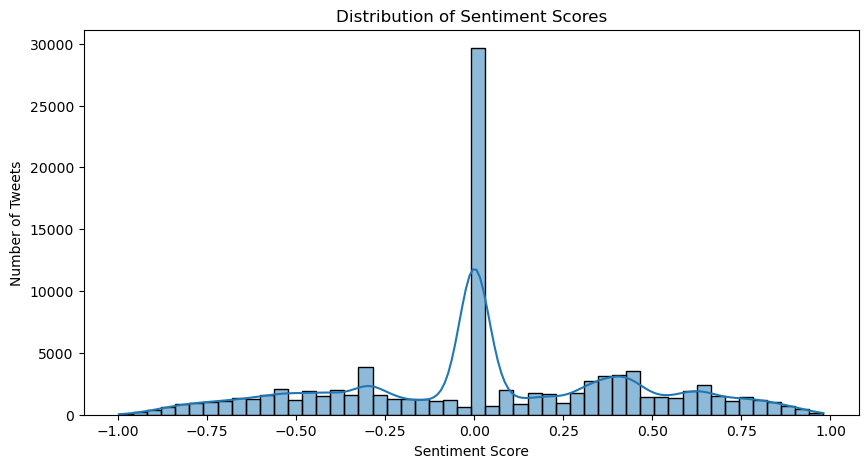

In [8]:
def visualize_sentiment_distribution(df):
    """Visualize the distribution of sentiment scores."""
    try:
        plt.figure(figsize=(10, 5))
        sns.histplot(df['sentiment'], bins=50, kde=True)
        plt.title('Distribution of Sentiment Scores')
        plt.xlabel('Sentiment Score')
        plt.ylabel('Number of Tweets')
        plt.grid(False)
        plt.show()
    except Exception as e:
        logging.error(f"Error visualizing sentiment distribution: {e}")

visualize_sentiment_distribution(df)

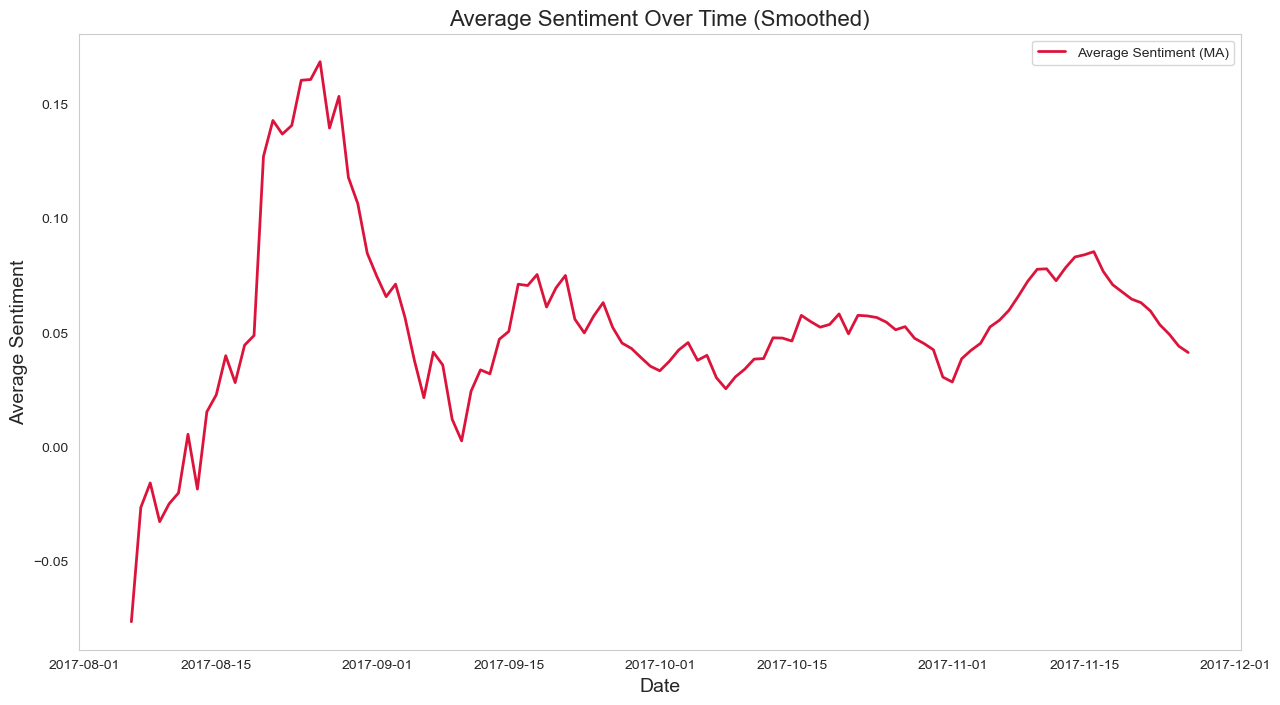

2023-12-11 13:25:00,714 - INFO - Smoothed time series plot for sentiment created successfully


In [9]:
def sentiment_over_time(df, date_column, sentiment_column, window_size=15):
    """
    Plot smoothed time series for sentiment.
    Args:
    df (pd.DataFrame): The dataframe containing the time series data.
    date_column (str): The name of the column containing the date.
    sentiment_column (str): The name of the column containing sentiment scores.
    window_size (int): The window size for the moving average, default is 7.
    """
    try:
        # Make a copy of the dataframe to avoid modifying the original
        temp_df = df.copy()
        
        # Ensure the date column is in the correct datetime format
        temp_df[date_column] = pd.to_datetime(temp_df[date_column])
        
        # Set the date as the index for the copy of the DataFrame
        temp_df = temp_df.set_index(date_column)
        
        # Resampling to daily frequency and calculating mean sentiment
        daily_sentiment = temp_df[sentiment_column].resample('D').mean()

        # Calculating the moving averages for sentiment
        sentiment_ma = daily_sentiment.rolling(window=window_size, center=True).mean()

        # Plot configuration
        sns.set_style("whitegrid")
        plt.figure(figsize=(15, 8))
        
        # Sentiment plot
        plt.plot(sentiment_ma.index, sentiment_ma, color='crimson', label='Average Sentiment (MA)', linewidth=2)
        
        # Title and labels
        plt.title('Average Sentiment Over Time (Smoothed)', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Average Sentiment', fontsize=14)
        plt.legend()
        plt.grid(False)

        plt.show()
        logging.info("Smoothed time series plot for sentiment created successfully")
    except Exception as e:
        logging.error(f"Error creating smoothed time series plot for sentiment: {e}")


# Apply the plotting function to your dataframe
sentiment_over_time(df, 'created_at', 'sentiment')

#### Sentiment Classification with Threshold: 

We classify the sentiment score column based on a threshold of 0.2 to -0.2 as neutral, above 0.2 would be classified as positive and below -0.2 as negative. Then, we will add the column to the dataframe and close the initial cleaning stage to continue with EDA.

In [9]:
# creating a column sentiment_class
def classify_sentiment(score):
    """
    Classify the sentiment of the tweets based on a sentiment score.
    Returns 'Positive', 'Negative', or 'Neutral' based on the score.
    score (float): The sentiment score to classify.
    Returns:
    str: The sentiment classification ('Positive', 'Negative', 'Neutral').
    """
    try:
        if score > 0.2:
            return 'Positive'
        elif score < -0.2:
            return 'Negative'
        else:
            return 'Neutral'
    except Exception as e:
        logging.error(f"Error in classifying sentiment: {e}")
        # Optionally, return a default classification or raise the exception
        return 'Neutral'  

# applying sentiment classification with threshold
try:
    df['sentiment_class'] = df['sentiment'].apply(classify_sentiment)
    logging.info("Sentiment classification applied successfully")
except Exception as e:
    logging.error(f"Error applying sentiment classification to DataFrame: {e}")

2023-12-04 15:51:26,165 - INFO - Sentiment classification applied successfully


In [10]:
# function to analyze the length of customer queries
def analyze_message_length(df, text_column):
    """
    Analyze the length of messages in a specified column.
    Args:
    df (pd.DataFrame): DataFrame containing the text data.
    text_column (str): Column name of the text data.
    Returns:
    pd.Series: A Series with the length of each message.
    """
    try:
        message_length = df[text_column].str.len()
        logging.info(f"Message length analysis for {text_column} completed successfully")
        return message_length
    except Exception as e:
        logging.error(f"Error in analyzing message length for {text_column}: {e}")
        return None

# Assuming 'text' is the column with customer inquiries in your DataFrame
inquiry_message_length = analyze_message_length(df, 'cleaned_text')

2023-12-11 13:25:22,322 - INFO - Message length analysis for cleaned_text completed successfully


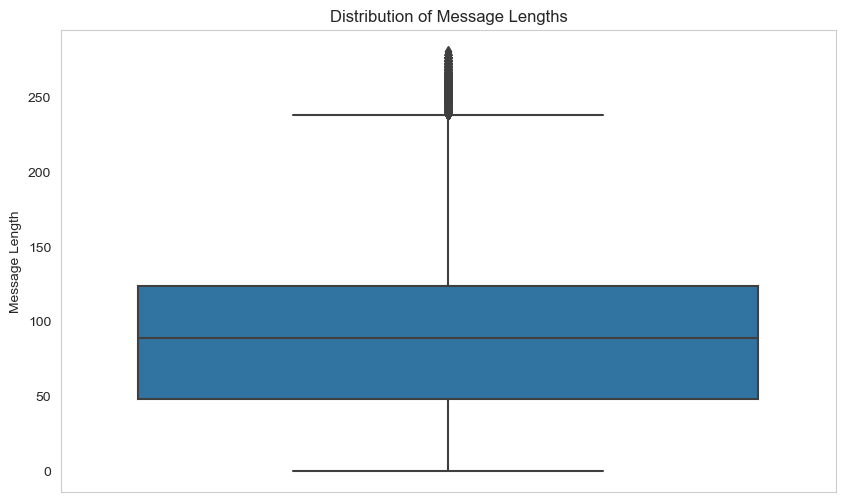

In [11]:
def plot_message_length_distribution(message_length):
    """
    Plot the distribution of message lengths.
    Args:
    message_length (pd.Series): Series containing the length of messages.
    """
    try:
        plt.figure(figsize=(10, 6))
        sns.boxplot(y=message_length)
        plt.title('Distribution of Message Lengths')
        plt.ylabel('Message Length')
        plt.grid(False)
        plt.show()
    except Exception as e:
        logging.error(f"Error in plotting message length distribution: {e}")

# Plotting the distribution of inquiry message lengths
plot_message_length_distribution(inquiry_message_length)

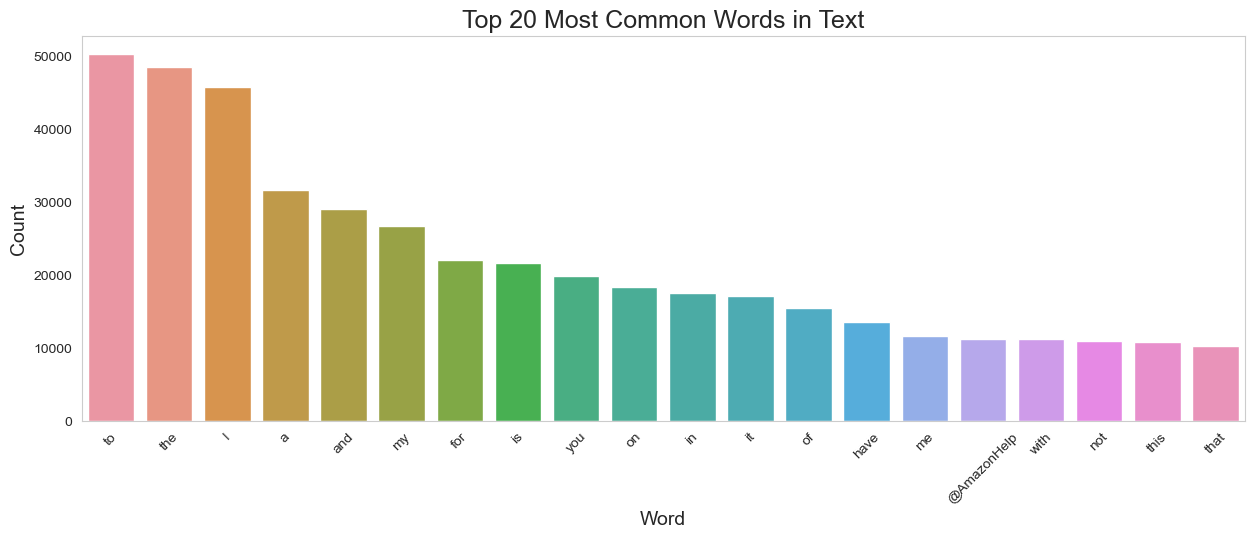

2023-12-11 13:28:38,628 - INFO - Visualization for top 20 common phrases/words in text completed


In [12]:
# function to plot common words and phrases to complement wordclouds 
def common_phrases_words_visualization(df, text_column, top_n=20):
    """
    Identify, count, and visualize the most common phrases or words in a specified column.
    Args:
    df (pd.DataFrame): DataFrame containing the text data.
    text_column (str): Column name of the text data.
    top_n (int): Number of top phrases or words to return and visualize.
    """
    try:
        # Join all text items into one large string and split into words
        all_words = ' '.join(df[text_column].dropna()).split()
        word_counts = Counter(all_words).most_common(top_n)
        
        # Create a DataFrame from the word counts
        words_df = pd.DataFrame(word_counts, columns=['word', 'count'])
        
        # Plotting
        plt.figure(figsize=(15, 5))
        sns.barplot(x='word', y='count', data=words_df)
        plt.xticks(rotation=45)
        plt.title(f'Top {top_n} Most Common Words in {text_column.title()}', fontsize=18)
        plt.xlabel('Word', fontsize=14)
        plt.ylabel('Count', fontsize=14)
        plt.grid(False)
        plt.show()
        
        logging.info(f"Visualization for top {top_n} common phrases/words in {text_column} completed")
    except Exception as e:
        logging.error(f"Error visualizing common phrases/words in {text_column}: {e}")

# Example usage with a DataFrame 'df' and a text column 'text'
common_phrases_words_visualization(df, 'text', top_n=20)

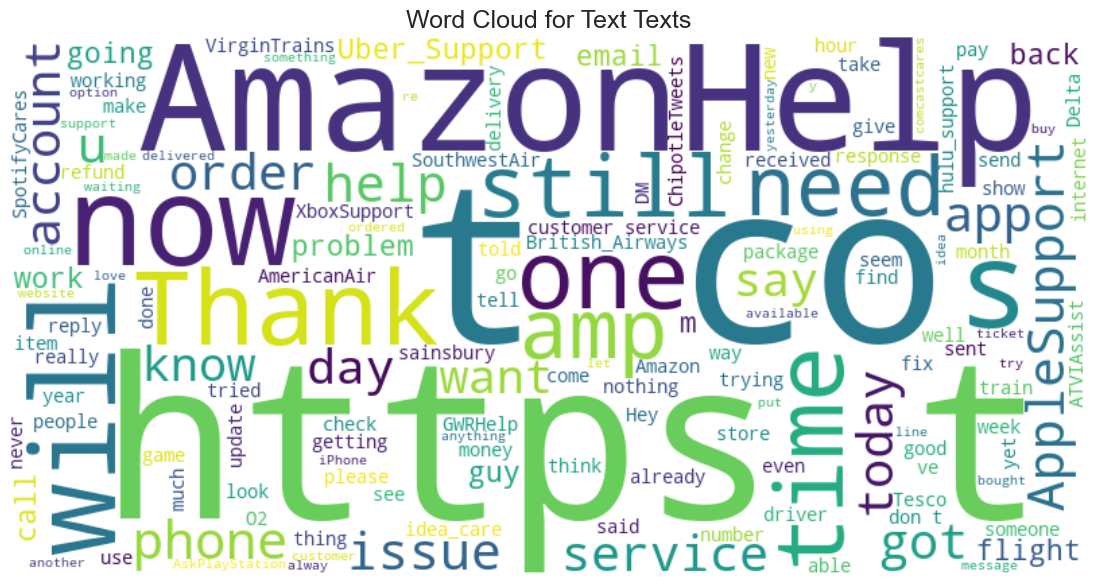

In [14]:
def generate_word_cloud(df, text_column):
    """
    Generate a word cloud for a specified column of text.
    Args:
    df (pd.DataFrame): DataFrame containing text data.
    text_column (str): Column name of the text data to visualize.
    """
    try:
        # Combine all texts into a single string
        combined_text = ' '.join(df[text_column].dropna())

        # Define word cloud parameters
        wc_params = {
            'stopwords': set(STOPWORDS),
            'background_color': 'white',
            'width': 800,
            'height': 400,
            'max_words': 150,
            'contour_width': 1,
            'contour_color': 'steelblue'
        }

        # Generate word cloud
        wordcloud = WordCloud(**wc_params).generate(combined_text)

        # Plotting the word cloud
        plt.figure(figsize=(15, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for {text_column.title()} Texts', fontsize=18)
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error generating word cloud for {text_column}: {e}")

# Assuming 'text' is the column in your DataFrame containing customer inquiries
generate_word_cloud(df, 'text')

#### Saving Cleaned Dataset:

The data is now cleaned and modeled to be in ideal form for the preprocessing and modeling stages which will come in the next notebook. Below we defined a function to save the data and add it to the utils py script. 

In [16]:
try:
    df['message_length'] = inquiry_message_length
    logging.info("Message length column added sucessfuly")
except Exception as e:
    logging.error(f"Error adding column to df: {e}")
    raise

2023-12-11 13:32:02,553 - INFO - Message length column added sucessfuly


In [17]:
# function to save data
def save_data(df, folder_path, file_name):
    """
    Saves the given DataFrame to a CSV file within the specified folder.
    df (pd.DataFrame): The DataFrame to be saved.
    folder_path (str): The path to the folder where the CSV file will be saved.
    file_name (str): The name of the CSV file.
    Returns:
    str: The full path to the saved CSV file, or None if an error occurred.
    """
    try:
        # Ensure the directory exists
        os.makedirs(folder_path, exist_ok=True)

        # Full path for the CSV file
        full_path = os.path.join(folder_path, file_name)

        # Save the DataFrame to CSV
        df.to_csv(full_path, index=False)
        
        logging.info(f"DataFrame saved successfully to {full_path}")
        return full_path
    except Exception as e:
        logging.error(f"Error saving the DataFrame to CSV: {e}")
        return None
# saving data
folder_path = '../data/'  # Adjust the path as needed
file_name = 'interim/cleaned_data.csv'
full_path = save_data(df, folder_path, file_name)

if full_path:
    print(f"DataFrame saved at: {full_path}")
else:
    print("Failed to save the DataFrame.")

2023-12-11 13:32:08,880 - INFO - DataFrame saved successfully to ../data/interim/cleaned_data.csv


DataFrame saved at: ../data/interim/cleaned_data.csv
